In [1]:
pip install torch==1.12.1 torchvision==0.13.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.4/776.4 MB 2.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 23.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.4 requires torch<1.12,>=1.7.0, but you have torch 1.12.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
import pathlib
import shutil 
import pandas as pd  # pip install pandas
from datetime import datetime
import os
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.io import ImageReadMode

In [3]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.12.1+cu102
torchvision version: 0.13.1+cu102


In [4]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.


In [5]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path)        
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
img_dir = '/notebooks/Dataset_H4/'

In [21]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([    
    transforms.Resize((550, 550)), # 1. Reshape all images to 512x512 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [22]:
data_train = CustomImageDataset('/notebooks/CSVs/target_train_h4.csv', img_dir=img_dir, transform=manual_transforms)
data_val = CustomImageDataset('/notebooks/CSVs/target_val_h4.csv', img_dir=img_dir, transform=manual_transforms)
data_test = CustomImageDataset('/notebooks/CSVs/target_test_h4.csv', img_dir=img_dir, transform=manual_transforms)

In [23]:
class_names = 5

In [24]:
train_dataloader = DataLoader(data_train, batch_size=32, shuffle=True)
val_dataloader = DataLoader(data_val, batch_size=32, shuffle=False)
test_dataloader = DataLoader(data_test, batch_size=32, shuffle=False)

train_dataloader, test_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f5fcfd292b0>,
 5)

In [31]:
# Get a set of pretrained model weights
weights = torchvision.models.RegNet_Y_400MF_Weights.IMAGENET1K_V1
weights

RegNet_Y_400MF_Weights.IMAGENET1K_V1

In [32]:
model = torchvision.models.regnet_y_400mf(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/regnet_y_400mf-c65dace8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_400mf-c65dace8.pth


  0%|          | 0.00/16.8M [00:00<?, ?B/s]

In [33]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(32, 3, 550, 550), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
RegNet (RegNet)                                              [32, 3, 550, 550]    [32, 1000]           --                   True
├─SimpleStemIN (stem)                                        [32, 3, 550, 550]    [32, 32, 275, 275]   --                   True
│    └─Conv2d (0)                                            [32, 3, 550, 550]    [32, 32, 275, 275]   864                  True
│    └─BatchNorm2d (1)                                       [32, 32, 275, 275]   [32, 32, 275, 275]   64                   True
│    └─ReLU (2)                                              [32, 32, 275, 275]   [32, 32, 275, 275]   --                   --
├─Sequential (trunk_output)                                  [32, 32, 275, 275]   [32, 440, 18, 18]    --                   True
│    └─AnyStage (block1)                                     [32, 32, 275, 275]   [32, 48, 138

In [34]:
for params in list(model.parameters())[0:-5]:
    params.requires_grad = False

In [35]:
# Set the manual seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Get the length of class_names (one output unit for each class)
output_shape = class_names

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True), 
    torch.nn.Linear(in_features=440, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [36]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       val_dataloader=val_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2654 | train_acc: 0.5686 | test_loss: 0.9043 | test_acc: 0.7590


KeyboardInterrupt: 

In [31]:
torch.cuda.empty_cache()

In [14]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B5_Weights.IMAGENET1K_V1 # .DEFAULT = best available weights from pretraining on ImageNet

model_load = torchvision.models.efficientnet_b5(weights=weights).to(device)

for params in list(model_load.parameters())[0:-5]:
    params.requires_grad = False
    
output_shape = len(class_names)    
model_load.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.5, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_load.parameters(), lr=0.001)
PATH = "/notebooks/models/model_efficientnet_b5_1.pth"
checkpoint = torch.load(PATH)
model_load.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-b6417697.pth


  0%|          | 0.00/117M [00:00<?, ?B/s]

In [15]:
# Set the random seeds
torch.manual_seed(17)
torch.cuda.manual_seed(17)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_load,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=14,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4799 | train_acc: 0.8092 | test_loss: 0.6774 | test_acc: 0.7305
Epoch: 2 | train_loss: 0.4495 | train_acc: 0.8216 | test_loss: 0.6733 | test_acc: 0.7384
Epoch: 3 | train_loss: 0.5277 | train_acc: 0.7919 | test_loss: 0.6576 | test_acc: 0.7360
Epoch: 4 | train_loss: 0.5255 | train_acc: 0.7888 | test_loss: 0.6641 | test_acc: 0.7469
Epoch: 5 | train_loss: 0.5631 | train_acc: 0.7750 | test_loss: 0.6531 | test_acc: 0.7315
Epoch: 6 | train_loss: 0.5589 | train_acc: 0.7763 | test_loss: 0.6418 | test_acc: 0.7463
Epoch: 7 | train_loss: 0.5558 | train_acc: 0.7765 | test_loss: 0.6474 | test_acc: 0.7477
Epoch: 8 | train_loss: 0.5569 | train_acc: 0.7774 | test_loss: 0.6323 | test_acc: 0.7466
Epoch: 9 | train_loss: 0.5537 | train_acc: 0.7788 | test_loss: 0.6329 | test_acc: 0.7474
Epoch: 10 | train_loss: 0.5505 | train_acc: 0.7787 | test_loss: 0.6428 | test_acc: 0.7468
Epoch: 11 | train_loss: 0.5494 | train_acc: 0.7799 | test_loss: 0.6325 | test_acc: 0.7513
Epoch: 12 | train_l

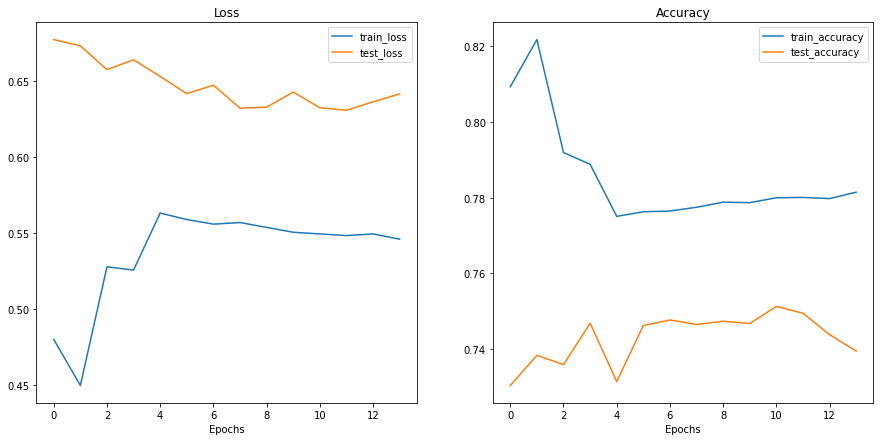

In [16]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
   with torch.inference_mode():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [ ]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])